<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/needs_scan_panel/needs_RSCCMM_CF_cluster_membership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

needs_scan_panel/needs_RSCCMM_CF_cluster_membership.ipynb

In [1]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv
import openpyxl as op

In [2]:
import pandas as pd
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs.shape)
print(test_needs)

(996, 18)
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


In [3]:
import numpy as np
import sys
import random

#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u, w

In [7]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  delta_max = 0
  every_cluster_objs_max = 0
  n_overlaps_max = 0
  rough_u_max = 0
  w_max = 0
  output = []

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rough_u, w = RSCCMM(X, C, delta) # RSCCM法を適用
    every_cluster_objs = np.sum(rough_u, axis=1) # 各クラスターの要素数
    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64)) # オーバーラップした要素数

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算
    output.append([auc, ', '.join(map(str, every_cluster_objs)), n_overlaps, X.shape[0] - n_overlaps])

    if auc > auc_max:
      auc_max = auc
      rough_u_max = rough_u
      w_max = w
      delta_max = delta
      every_cluster_objs_max = every_cluster_objs
      n_overlaps_max = n_overlaps


  return auc_max, rough_u, every_cluster_objs_max, n_overlaps_max, w_max, output

auc_max, rough_u_max, every_cluster_objs_max, n_overlaps_max, w_max, output = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, 100, -7)


[ 38.  37.   2.  21.  35.  31.  85.  46.  62.  35.  80.  44.  53.  54.
  36.  28.  42.  40.  97.  67.  62.  54.  73.  41.  61.  96.  64.  27.
  10.  24.   9.  70.   3.  46.  23.  31.  89.  79.  30.  36.   2.  34.
  12.  47.  36.  28.   1.   7.  16.  46.  32.  15.  68.  42.   1.  31.
  15.   3.   9.   2.  40.   9.  47.  10.  21.  64.  21.  36.   6.  29.
  67.  50.  89.  94.  39.  20.  97.  72.   2.   3.  19.   8.  33.   5.
  10.  93.  72.  23.  46.  67.  62.   3.  20.  21.  34.  46.  18.  46.
  70.  31.  42.  51.  58.   1.  13.  66.   4.  93.  51.   1.   6.  58.
  30.  54.  62.  46.  66.  26.   4.  70.  45.  40.  65.  58.  14.   1.
  77.  11.   2.  46.   7.  62.  11.  50.   4.  44.   2.   7.  10.  50.
  39.  18.   9.  43.  11.  43.   2.  32.  16.  17.  49.   6.  21.  53.
  61.  94.  25.   5.  62.   6.   5.  14.  40.  27.   2.  38.  32.  26.
  82. 100.   2.  65.  19.  11.  28.  23.  37.  55.   3.  55.  47.   2.
  59.  25.   1.  17.  81.  50.   1.  66.  10.  59.  10.  53.  71.  37.
  60. 

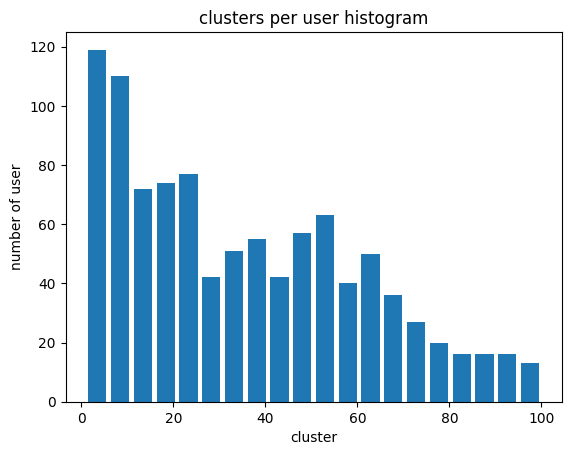

In [15]:
n_clusters_per_obj = np.sum(rough_u_max, axis=0) # 各対象が、いくつのクラスターに属しているか

print(n_clusters_per_obj)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(n_clusters_per_obj, bins=20, rwidth=0.8)
ax.set_title('clusters per user histogram')
ax.set_xlabel('cluster')
ax.set_ylabel('number of user')
fig.show()

- 80から100このクラスターに属しているユーザーが70人くらいいる
- 一番多くいるのは1から10個のクラスターに属しているユーザー

→多くのクラスターに属している対象がモデルユーザー、あまりクラスターに属していないユーザーをノイズと考えるなら、クラスターを増やすごとにノイズが省かれて行って、ノイズ除去機構のように働いたと考えるのが妥当？

ただ、例えば、一つのクラスターにだけ属しているユーザーがいたとして、そのクラスターは何人のユーザーを持っているのか、というようなことも確認しないといけない。（11/14）


[['AUC', '各クラスターの要素数', 'オーバーラップしている要素の数', 'オーバーラップしていない要素の数'], [0.8473652734400956, '156.0, 512.0, 237.0, 541.0, 429.0, 529.0, 364.0, 691.0, 542.0, 417.0, 281.0, 402.0, 367.0, 526.0, 568.0, 240.0, 442.0, 760.0, 434.0, 566.0, 462.0, 64.0, 43.0, 187.0, 473.0, 239.0, 506.0, 450.0, 387.0, 64.0, 241.0, 556.0, 43.0, 657.0, 64.0, 308.0, 269.0, 454.0, 288.0, 568.0, 313.0, 773.0, 198.0, 326.0, 684.0, 367.0, 66.0, 43.0, 181.0, 167.0, 613.0, 572.0, 43.0, 43.0, 360.0, 515.0, 43.0, 146.0, 123.0, 646.0, 354.0, 43.0, 108.0, 413.0, 610.0, 293.0, 269.0, 443.0, 308.0, 110.0, 121.0, 516.0, 43.0, 511.0, 321.0, 43.0, 341.0, 324.0, 644.0, 332.0, 43.0, 350.0, 320.0, 202.0, 678.0, 435.0, 129.0, 512.0, 43.0, 43.0, 290.0, 594.0, 464.0, 43.0, 570.0, 75.0, 258.0, 292.0, 736.0, 167.0', 962.0, 34.0]]


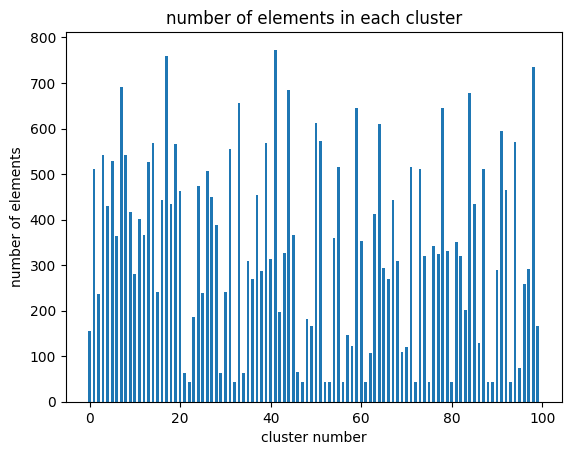

In [5]:
# 可視化
name = "needs_RSCCMM_cluster"
C = 100
auc_max, every_cluster_objs_max, n_overlaps_max, w_max, output = RSCCMM_CF_AUC_CLUSTER(1, test_needs, X_needs, C, -7)

plt.bar(range(C), every_cluster_objs_max, width=0.6)

# plt.legend()
plt.title('number of elements in each cluster')
plt.xlabel('cluster number')
plt.ylabel('number of elements')
plt.savefig(f"{name}.png", format="png", dpi=300)

csv_output = [["AUC", "各クラスターの要素数", "オーバーラップしている要素の数", "オーバーラップしていない要素の数"]]
for row in output:
  csv_output.append(row)
print(csv_output)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(csv_output)

In [ ]:
対象別で所属しているクラスターの数